In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict


from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

sys.path.append('..')

from utils.dataset import DatasetReader
from utils.metrics import mse, psnr
from models.baseline import Baseline

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(0)

# Get Data

In [4]:
dr = DatasetReader(dataset_path='../temp/PUC_DIR')

In [12]:
x_train, y_train, x_val, y_val, _, _ = dr.get_dataset(img_size=64)

In [13]:
x_train[0].shape, y_train[0].shape

((32, 32), (64, 64))

In [16]:
len(x_train)

1064

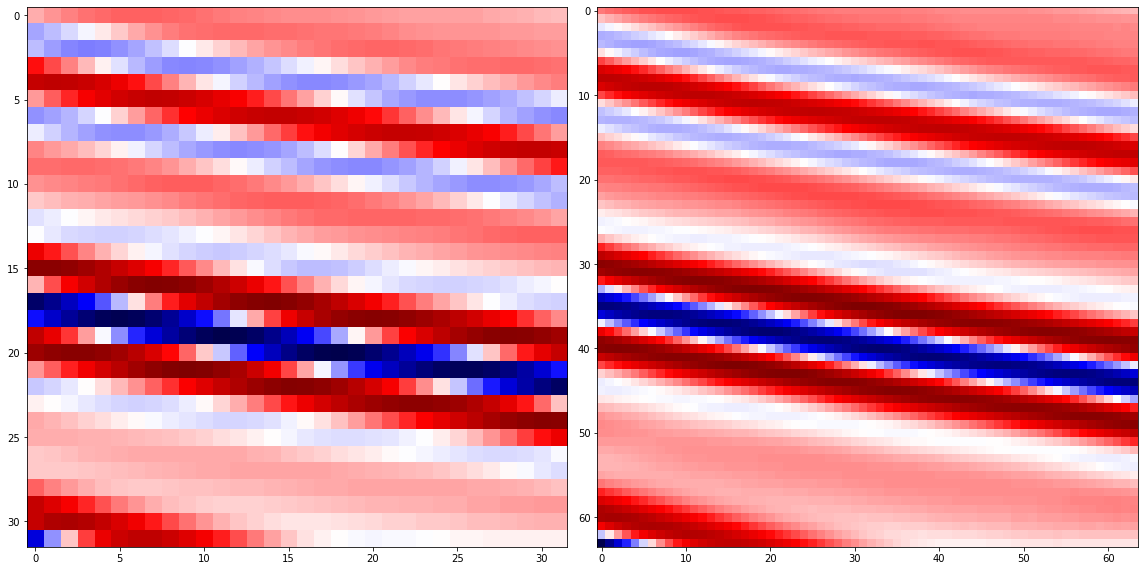

In [17]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(x_train[999], cmap='seismic')

ax[1].imshow(y_train[999], cmap='seismic')

plt.tight_layout()
plt.show()

# MLP

In [8]:
tf.keras.backend.set_floatx('float64')

class MLP(tf.keras.Model):
    def __init__(self, int_dims, original_dim=64, learning_rate=0.001, activ_hidden=tf.nn.relu, activ_out=None):
        super(MLP, self).__init__()
        
        self.resolution = original_dim
        
        self.activation_hidden_layer = activ_hidden
        self.activation_output_layer = activ_out
        
        self.hidden_layers = []

        for i in range(len(int_dims)):
            self.hidden_layers.append(tf.keras.layers.Dense(
                units=int_dims[i],
                activation=activ_hidden,
                kernel_initializer='he_uniform'))
        
        self.output_layer = tf.keras.layers.Dense(
                units=self.resolution**2,
                activation=activ_out,
                kernel_initializer='he_uniform')
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.loss_metric = tf.keras.metrics.MeanSquaredError()
        
        self.loss = tf.keras.losses.MeanSquaredError()
        
        self.log_metrics = defaultdict(list)
        
        self.learning_rate = learning_rate

    def call(self, input_features):
        result = tf.reshape(input_features, (-1, (self.resolution//2)**2))
        for i in range(len(self.hidden_layers)):
            result = self.hidden_layers[i](result)
        
        out = self.output_layer(result)
        
        return tf.reshape(out, (-1, self.resolution, self.resolution))

    @tf.function
    def train(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x)
            
            loss_value = self.loss(predictions, y)
            
            self.loss_metric.update_state(predictions, y)
                        
            gradients = tape.gradient(loss_value, self.trainable_variables)
            
            gradient_variables = zip(gradients, self.trainable_variables)
            
            self.optimizer.apply_gradients(gradient_variables)
            
            return loss_value

    def make_dataset(self, x, y, x_val, y_val):
        x_train = tf.data.Dataset.from_tensor_slices(x)
        x_val = tf.data.Dataset.from_tensor_slices(x_val)
        
        y_train = tf.data.Dataset.from_tensor_slices(y)
        y_val = tf.data.Dataset.from_tensor_slices(y_val)
            
        return x_train, y_train, x_val, y_val

    def train_epochs(self, x_train, y_train, x_val, y_val, n_epochs, batch_size, SEED=42):
        x_train, y_train, x_val, y_val = self.make_dataset(x_train, y_train, x_val, y_val)
        loss = []
        for epoch in range(n_epochs):
            loss_val = []
            batches_x = x_train.batch(batch_size)
            batches_y = y_train.batch(batch_size)
            
            # Training loop
            for _x, _y in zip(batches_x, batches_y):
                self.train( _x, _y)
            
            batches_x_val = x_val.batch(batch_size)
            batches_y_val = y_val.batch(batch_size)
            
            # Validation loop
            for _x, _y in zip(batches_x, batches_y):
                loss_val.append(self.loss(self(_x), _y))

            loss_train = self.loss_metric.result().numpy()
            
            if epoch%20 == 0 or epoch == 0:
                print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
            loss.append(np.mean(loss_val))

            self.log_metrics['loss_train'].append(loss_train)
            self.log_metrics['loss_val'].append(np.mean(loss_val))

            self.loss_metric.reset_states()
       
        print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
        return pd.DataFrame(self.log_metrics)


In [16]:
model = MLP([2048])

In [17]:
_ = model(np.random.random_sample((1, 32, 32)))

model.summary()

Model: "mlp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  2099200   
_________________________________________________________________
dense_3 (Dense)              multiple                  8392704   
_________________________________________________________________
mean_squared_error (MeanSqua multiple                  2         
Total params: 10,491,906
Trainable params: 10,491,904
Non-trainable params: 2
_________________________________________________________________


## Train

In [25]:
result = model.train_epochs(x_train, y_train, x_val, y_val, 500, 64)

Epoch: 0 Train Loss: 2.1814935374603373e-05 Validation Loss: 1.108731248677941e-05
Epoch: 20 Train Loss: 2.4599318767162693e-05 Validation Loss: 1.647279532335233e-05
Epoch: 40 Train Loss: 2.6703677228774048e-05 Validation Loss: 1.9045768567593768e-05
Epoch: 60 Train Loss: 2.102476269331925e-05 Validation Loss: 1.4977622413425706e-05
Epoch: 80 Train Loss: 2.487075667411078e-05 Validation Loss: 1.8962498870678246e-05
Epoch: 100 Train Loss: 2.1276365821118563e-05 Validation Loss: 1.4321452908916399e-05
Epoch: 120 Train Loss: 2.3238016168545334e-05 Validation Loss: 1.5408037143060938e-05
Epoch: 140 Train Loss: 2.1272794882626313e-05 Validation Loss: 1.4556135283783078e-05
Epoch: 160 Train Loss: 2.4895901736073064e-05 Validation Loss: 1.7120788470492698e-05
Epoch: 180 Train Loss: 2.177019748343962e-05 Validation Loss: 1.4740506230737083e-05
Epoch: 200 Train Loss: 1.919764711161294e-05 Validation Loss: 1.345084729109658e-05
Epoch: 220 Train Loss: 2.1751322956636534e-05 Validation Loss: 1.63

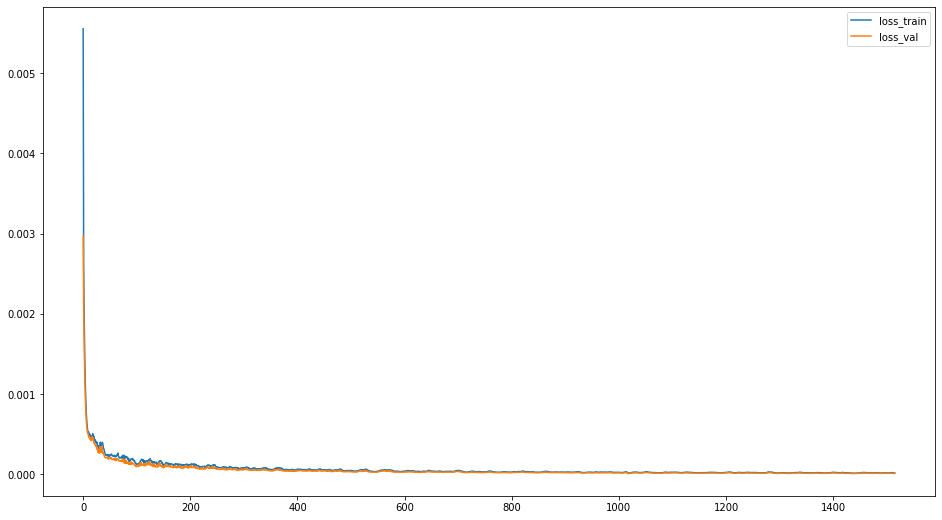

In [31]:
result.plot()

In [32]:
y = model(x_train)

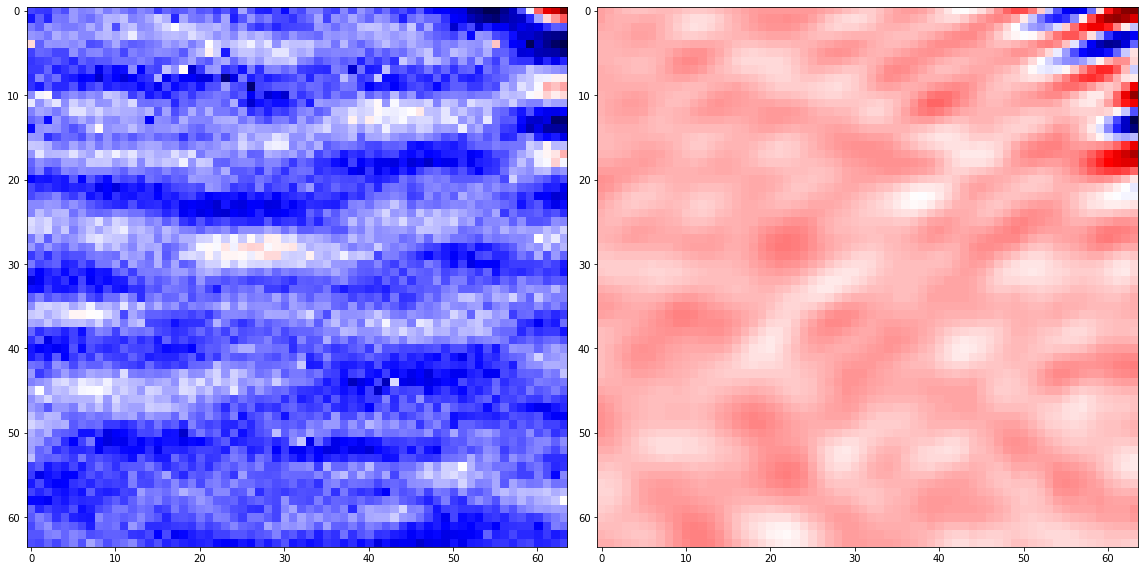

In [33]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[1], cmap='seismic')

ax[1].imshow(y_train[1], cmap='seismic')

plt.tight_layout()
plt.show()

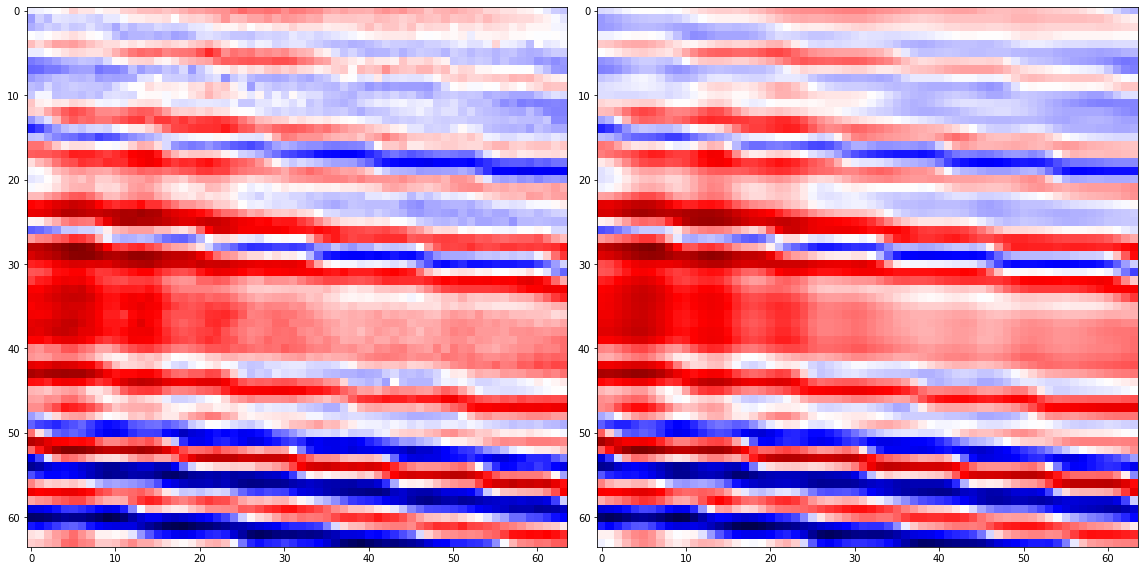

In [34]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[21], cmap='seismic')

ax[1].imshow(y_train[21], cmap='seismic')

plt.tight_layout()
plt.show()

In [35]:
_ = mse(y_train, y)
_ = psnr(y_train, y)

Mean MSE 1.1179137808405245e-05
Mean PSNR 55.52281149619396


### Baseline

In [11]:
baseline = Baseline()
y_b = baseline.predict(x_train)
_ = baseline.evaluate(x_train, y_train)

Mean MSE 0.00011966525845741003
Mean PSNR 53.322193156200285


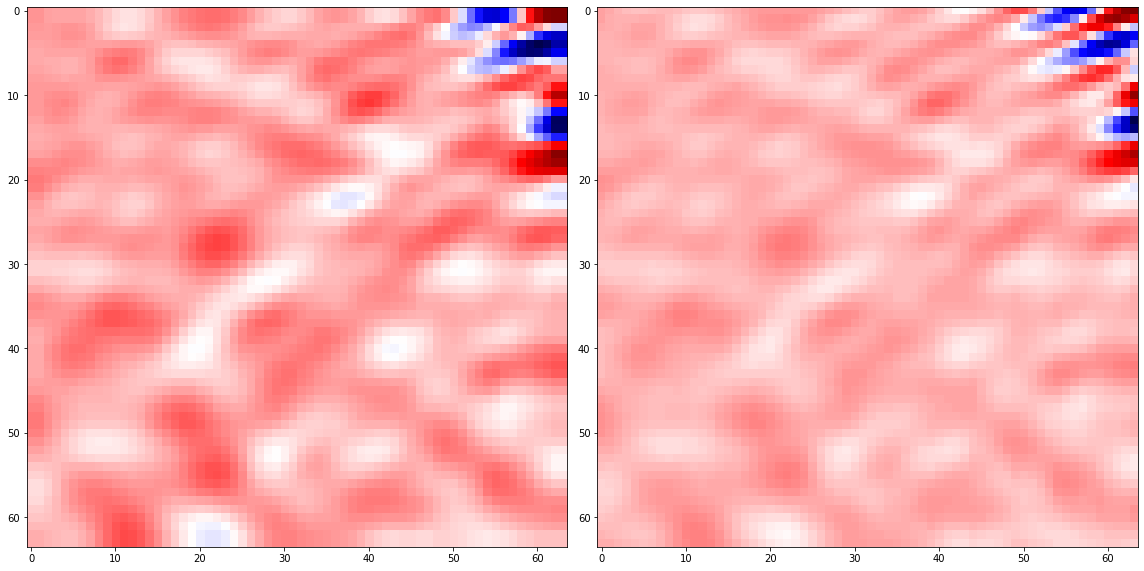

In [12]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[1], cmap='seismic')

ax[1].imshow(y_train[1], cmap='seismic')

plt.tight_layout()
plt.show()

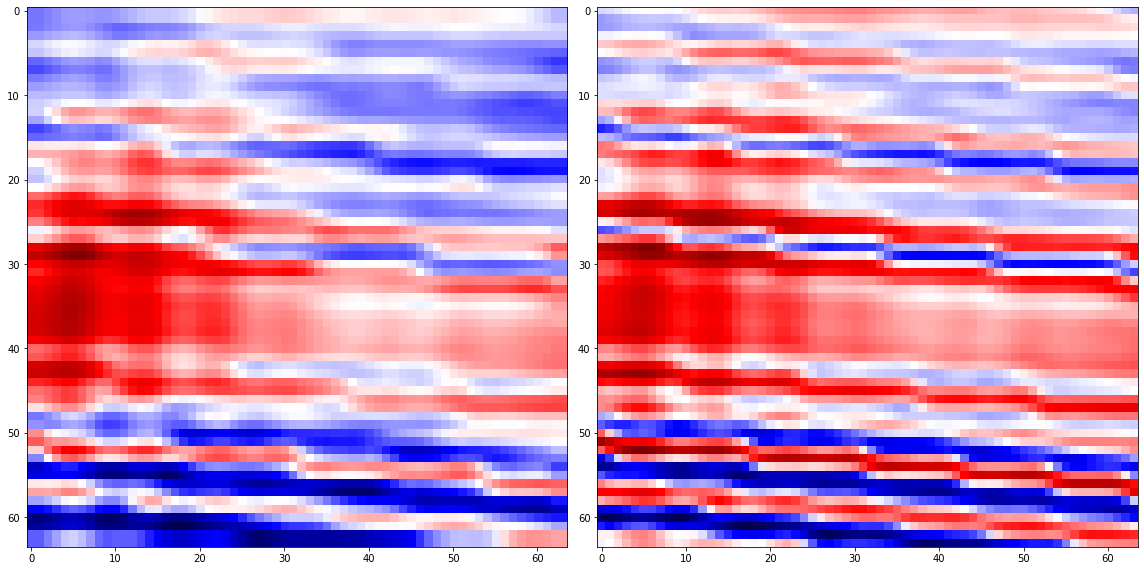

In [13]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[21], cmap='seismic')

ax[1].imshow(y_train[21], cmap='seismic')

plt.tight_layout()
plt.show()